In [3]:
import math
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import random
import os
import json
import warnings
warnings.filterwarnings("ignore")

2023-06-17 18:49:57.047933: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-17 18:49:57.276266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-17 18:49:58.273706: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



# Split dataset
The dataset is split into the sections:
- Training
- Validation
- Test


In [4]:
# Directory containing dataset
data_directory = os.path.join(
    "archive", "plantvillage dataset", "color"
)

split_dataset_dir = "split_dataset"

In [12]:
# Make folders to hold dataset
os.mkdir(split_dataset_dir)
os.mkdir(os.path.join(split_dataset_dir, "train"))
os.mkdir(os.path.join(split_dataset_dir, "validation"))
os.mkdir(os.path.join(split_dataset_dir, "test"))

In [7]:
def split_train_validation_test(
    from_directory: str,
    destination_directory: str,
    test_percent: int = 1,
    validation_percent: int = 20,
) -> None:
    """
    Copy image files from folder into the destination folder split into three
    folders: train, validation, test.
    :param from_directory: Directory containing images.
    :param destination_directory: Destination directory.
    :param test_percent: Percent of total images by type to go into this folder.
    :param validation_percent: Percent of total images by type to go into this folder.
    :return: None.
    """
    dataset_dirs = ["test", "validation", "train"]
    split_percent = (test_percent, validation_percent, 100)
    images_copied = set()
    folders = os.listdir(from_directory)
    for index, split_dir in enumerate(dataset_dirs):
        print("Copying .. ", end="")
        print("\n")
        for folder in folders:
            folder_path = os.path.join(from_directory, folder)

            # Get list of images and filter out already copied images
            images = os.listdir(folder_path)
            images = list(set(images) - images_copied)

            # Number of images to copy
            num_of_images = math.ceil(len(images) * (split_percent[index] / 100))
            os.mkdir(os.path.join(destination_directory, split_dir, folder))
            for _ in range(num_of_images):
                # Copy a random image from the folder
                image = images.pop(random.randint(0, len(images) - 1))
                images_copied.add(image)
                shutil.copy(
                    os.path.join(folder_path, image),
                    os.path.join(destination_directory, split_dir, folder),
                )
    print("Done.")

In [8]:
# Load images into folder split into train, validation, and test folders.
split_train_validation_test(data_directory, split_dataset_dir)



Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. 

Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. 

Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copying .. Copy

# Load datasets

In [401]:
# Training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(split_dataset_dir, "train"),
    labels="inferred",
    label_mode="int",
    seed=123,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

Found 42939 files belonging to 38 classes.


In [402]:
# Validation data
validation_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(split_dataset_dir, "validation"),
    labels="inferred",
    label_mode="int",
    seed=123,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=False,
)

Found 10815 files belonging to 38 classes.


# Visualize dataset

In [403]:
# Category names
class_names = train_ds.class_names
train_ds.class_names

short_class_names = [cate.replace("___", "-")[:35].replace("_", '-') for cate in class_names]
short_class_names

['Apple-Apple-scab',
 'Apple-Black-rot',
 'Apple-Cedar-apple-rust',
 'Apple-healthy',
 'Blueberry-healthy',
 'Cherry-(including-sour)-Powdery-mil',
 'Cherry-(including-sour)-healthy',
 'Corn-(maize)-Cercospora-leaf-spot G',
 'Corn-(maize)-Common-rust-',
 'Corn-(maize)-Northern-Leaf-Blight',
 'Corn-(maize)-healthy',
 'Grape-Black-rot',
 'Grape-Esca-(Black-Measles)',
 'Grape-Leaf-blight-(Isariopsis-Leaf-',
 'Grape-healthy',
 'Orange-Haunglongbing-(Citrus-greeni',
 'Peach-Bacterial-spot',
 'Peach-healthy',
 'Pepper,-bell-Bacterial-spot',
 'Pepper,-bell-healthy',
 'Potato-Early-blight',
 'Potato-Late-blight',
 'Potato-healthy',
 'Raspberry-healthy',
 'Soybean-healthy',
 'Squash-Powdery-mildew',
 'Strawberry-Leaf-scorch',
 'Strawberry-healthy',
 'Tomato-Bacterial-spot',
 'Tomato-Early-blight',
 'Tomato-Late-blight',
 'Tomato-Leaf-Mold',
 'Tomato-Septoria-leaf-spot',
 'Tomato-Spider-mites Two-spotted-spi',
 'Tomato-Target-Spot',
 'Tomato-Tomato-Yellow-Leaf-Curl-Viru',
 'Tomato-Tomato-mosaic-

In [404]:
# Genterating image stats.

# This will be stored for the *Python server* to use. The "map" field will be used by
# the server to find the category of a prediction made by this model.
image_info = {"categories": [], "map": []}

# Returns items that end with any of the filter strings.
def filter_list(items, *filters):
    return_list = []
    for item in items:
        if (any([item.casefold().endswith(string) for string in filters])):
            return_list.append(item)
    return return_list
   
total = 0
map_plant_index = -1
map_plant_disease_index = 0   

plant_obj = {}

for name in class_names:
    # Split the category names into plant and disease.
    plant, disease = name.split('___')
    
    # Collect the total number of images.
    # This is filtered in case the directory contains any metadata files. 
    total += len(filter_list(os.listdir(os.path.join(data_directory, name)), ".jpg", ".jpeg", ".png"))
    
    plant = plant.replace("_", " ").strip(" ")
    
    # A space in the name means that the follow text is another name for the disease.
    # This statement will wrap that text in parenthesis.
    if " " in disease:
        disease = disease.replace(" ", " (") + ")"
    
    disease = disease.replace("_", " ").strip(" ")
    
    
    # Append the disease of the plant it belongs to with the number of images in that disease.
    if plant in [plant_info["name"] for plant_info in image_info["categories"]]:
        plant_obj["diseases"].append({"name": disease, "number": len(filter_list(os.listdir(os.path.join(data_directory, name)), ".jpg", ".jpeg", ".png"))})
        image_info["map"].append([map_plant_index, map_plant_disease_index]) 
        map_plant_disease_index += 1
    else:
        plant_obj = {"name": plant, "diseases": []}
        map_plant_disease_index = 0
        map_plant_index += 1
        image_info["categories"].append(plant_obj)
        plant_obj["diseases"].append({"name": disease, "number": len(filter_list(os.listdir(os.path.join(data_directory, name)), ".jpg", ".jpeg", ".png"))})
        image_info["map"].append([map_plant_index, map_plant_disease_index]) 
        map_plant_disease_index = 1


image_info["total"] = total

# Save data
with open("image_info.json", "w") as image_info_file:
    json.dump(image_info, image_info_file)

In [405]:
# Get count of images
ds_leaf_count = []
for cate in image_info["categories"]:
    for disease in cate["diseases"]:
        ds_leaf_count.append(disease["number"])

<Axes: xlabel='Category image count', ylabel='Category'>

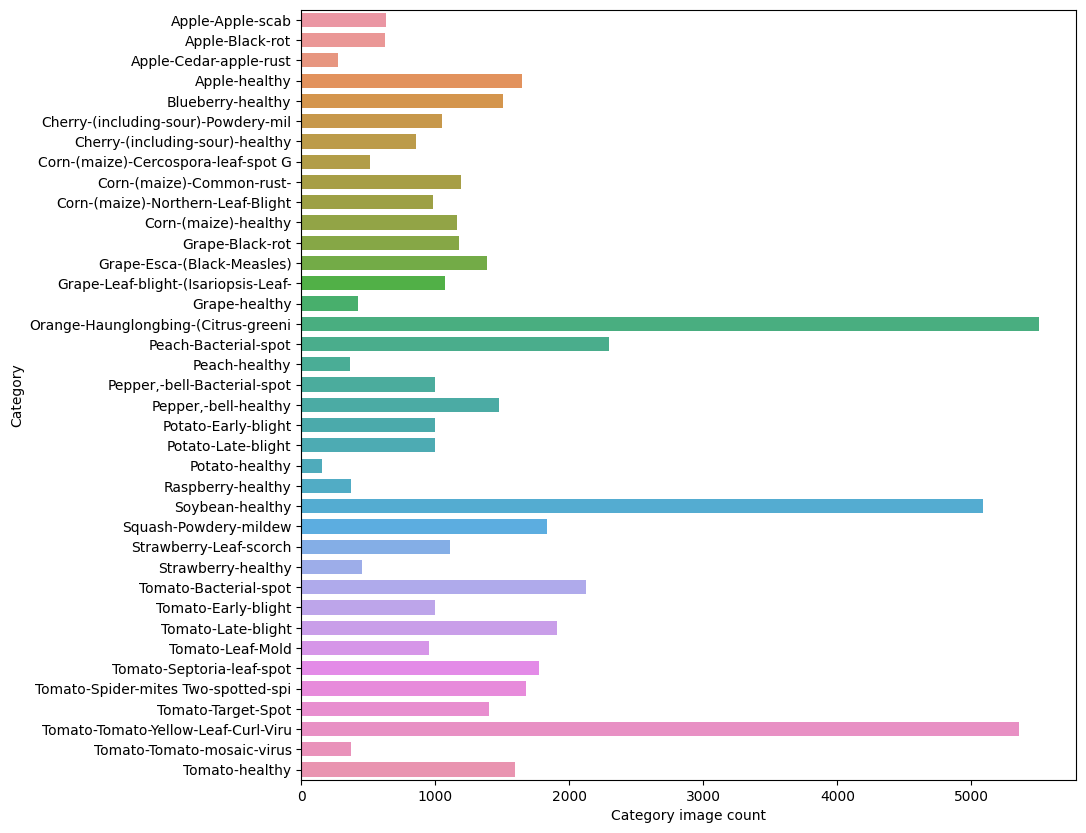

In [406]:
# Image count
_, ax = plt.subplots(figsize=(10, 10))
ax.set(xlabel="Category image count", ylabel="Category")
sns.barplot(data=pd.DataFrame([ds_leaf_count], columns=short_class_names), orient="h", width=.7, linewidth=2)

In [407]:
# Get count of images grouped by category
ds_leaf_count_grouped = []
for index, cate in enumerate(image_info["categories"]):
    ds_leaf_count_grouped.append(0)
    for disease in cate["diseases"]:
        ds_leaf_count_grouped[index] += (disease["number"])

In [408]:
plant_names = [cate["name"] for cate in image_info["categories"]]

<Axes: xlabel='Plant image count', ylabel='Plants'>

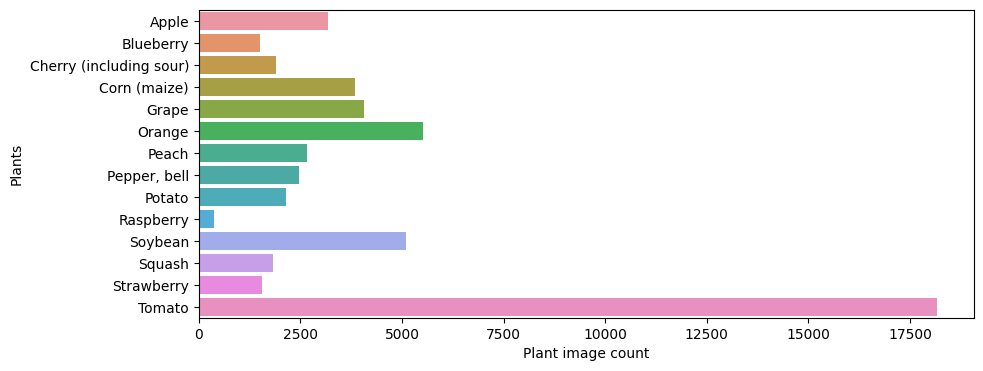

In [443]:
# Image count grouped by plant
_, ax = plt.subplots(figsize=(10, 4))
ax.set(xlabel="Plant image count", ylabel="Plants")
sns.barplot(data=pd.DataFrame([ds_leaf_count_grouped], columns=plant_names), orient='h')

# Create Model

In [469]:
# Used as the base model (Transfer Learning)
base_model = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3), weights="imagenet", include_top=False, 
)

In [470]:
# Do not train this model.
base_model.trainable = False

In [471]:
# Augmentation of data
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(factor=0.2),
        tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
        tf.keras.layers.RandomBrightness((-0.1, 0.1)),
    ]
)

In [472]:
# Rescale the image
image_size_and_scale = tf.keras.Sequential(
    [tf.keras.layers.Resizing(224, 224), tf.keras.layers.Rescaling(1.0 / 255)]
)

In [473]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(256, 256, 3)),
        augmentation,
        image_size_and_scale,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1028, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(class_names), activation="softmax"),
    ]
)

In [474]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=["accuracy"],
)

In [475]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

In [476]:
model.summary()

Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_114 (Sequential)  (None, 256, 256, 3)      0         
                                                                 
 sequential_115 (Sequential)  (None, 224, 224, 3)      0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_38  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_76 (Dense)            (None, 1028)              1053700   
                                                                 
 dropout_38 (Dropout)        (None, 1028)           

In [477]:
results = model.fit(
    train_ds, validation_data=validation_ds, epochs=30, callbacks=[stop_early], 
)

Epoch 1/30
1342/1342 [==============================] - 71s 51ms/step - loss: 0.5166 - accuracy: 0.8418 - val_loss: 0.2302 - val_accuracy: 0.9238
Epoch 2/30
1342/1342 [==============================] - 68s 51ms/step - loss: 0.3046 - accuracy: 0.8997 - val_loss: 0.2152 - val_accuracy: 0.9297
Epoch 3/30
1342/1342 [==============================] - 68s 51ms/step - loss: 0.2776 - accuracy: 0.9092 - val_loss: 0.1757 - val_accuracy: 0.9426
Epoch 4/30
1342/1342 [==============================] - 68s 51ms/step - loss: 0.2511 - accuracy: 0.9178 - val_loss: 0.1576 - val_accuracy: 0.9478
Epoch 5/30
1342/1342 [==============================] - 68s 51ms/step - loss: 0.2441 - accuracy: 0.9211 - val_loss: 0.1595 - val_accuracy: 0.9469
Epoch 6/30
1342/1342 [==============================] - 68s 51ms/step - loss: 0.2312 - accuracy: 0.9262 - val_loss: 0.1647 - val_accuracy: 0.9470
Epoch 7/30
1342/1342 [==============================] - 68s 51ms/step - loss: 0.2215 - accuracy: 0.9284 - val_loss: 0.1426 -

In [478]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=1)
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=["accuracy"],
)

In [479]:
results_fine_tune = model.fit(
    train_ds, validation_data=validation_ds, epochs=10, callbacks=[stop_early], 
)

Epoch 1/10
1342/1342 [==============================] - 174s 123ms/step - loss: 0.8158 - accuracy: 0.8445 - val_loss: 0.2499 - val_accuracy: 0.9365
Epoch 2/10
1342/1342 [==============================] - 166s 124ms/step - loss: 0.3096 - accuracy: 0.9223 - val_loss: 0.1697 - val_accuracy: 0.9551
Epoch 3/10
1342/1342 [==============================] - 167s 124ms/step - loss: 0.2281 - accuracy: 0.9378 - val_loss: 0.1456 - val_accuracy: 0.9612
Epoch 4/10
1342/1342 [==============================] - 167s 124ms/step - loss: 0.1823 - accuracy: 0.9486 - val_loss: 0.1278 - val_accuracy: 0.9647
Epoch 5/10
1342/1342 [==============================] - 167s 124ms/step - loss: 0.1487 - accuracy: 0.9572 - val_loss: 0.1096 - val_accuracy: 0.9703
Epoch 6/10
1342/1342 [==============================] - 166s 124ms/step - loss: 0.1245 - accuracy: 0.9625 - val_loss: 0.0998 - val_accuracy: 0.9726
Epoch 7/10
1342/1342 [==============================] - 166s 124ms/step - loss: 0.1204 - accuracy: 0.9630 - val_

# Visualize model performance

In [ ]:
# Join all results together.
dfs = [pd.DataFrame(results.history), pd.DataFrame(results_fine_tune.history)]
results_total = pd.concat(dfs)
results_total = results_total.set_index(np.arange(0, len(results_total["loss"])))

## Loss

Text(0, 0.5, 'Loss')

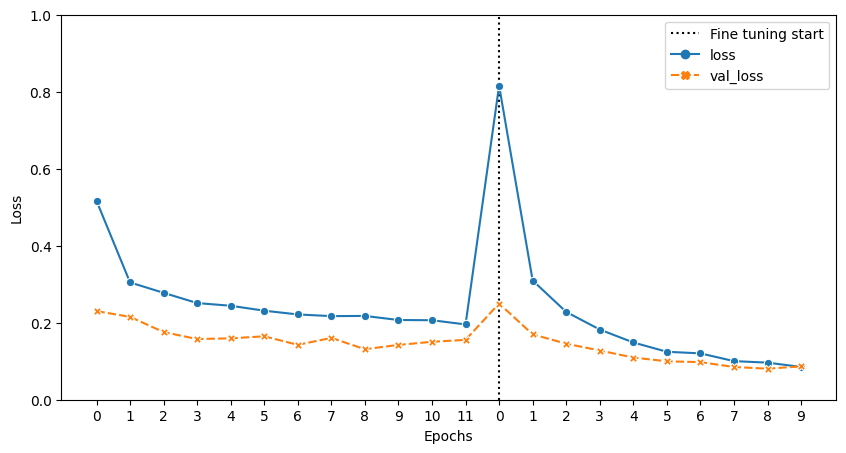

In [548]:
# View loss on a line graph.
plt.figure(figsize=(10, 5))
line = plt.vlines(len(results.history['loss']), color="black", ymin=0, ymax=10, linestyles="dotted", label="Fine tuning start")
g = sns.lineplot(results_total[['loss', 'val_loss']], markers=True)
g.set_xticks(np.arange(0, len(results_total['loss'])))
g.set_xticklabels(np.concatenate((np.arange(0, len(results.history['loss'])), np.arange(0, len(results_fine_tune.history['loss'])))))
g.set_ylim(0, 1)
g.set_xlabel("Epochs")
g.set_ylabel("Loss")

## Accuracy

Text(0, 0.5, 'Accuracy')

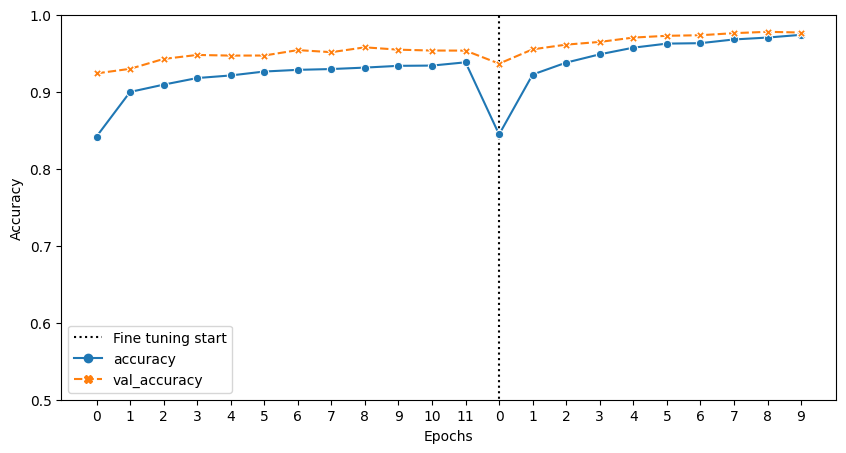

In [549]:
# View accuracy on a line graph.
plt.figure(figsize=(10, 5))
line = plt.vlines(len(results.history['accuracy']), color="black", ymin=0, ymax=10, linestyles="dotted", label="Fine tuning start")
g = sns.lineplot(results_total[['accuracy', 'val_accuracy']], markers=True)
g.set_xticks(np.arange(0, len(results_total['accuracy'])))
g.set_xticklabels(np.concatenate((np.arange(0, len(results.history['accuracy'])), np.arange(0, len(results_fine_tune.history['accuracy'])))))
g.set_ylim(.5, 1)
g.set_xlabel("Epochs")
g.set_ylabel("Accuracy")

## Confusion matrix

In [522]:
# Get the predictions for each image in the validation set.
val_results = model.predict(validation_ds)

338/338 [==============================] - 12s 33ms/step


In [523]:
len(val_results)

10815

In [524]:
# Get validation dataset images true categories.
val_true = []
for i, folder in enumerate(class_names):
    prediction = [i for _ in range(len(filter_list(os.listdir(os.path.join(split_dataset_dir, "validation", folder)), 
                                                   ".jpg", 
                                                   ".jpeg", 
                                                   ".png")))]
    val_true.extend(prediction)

Text(0.5, 102.72222222222219, 'True Prediction')

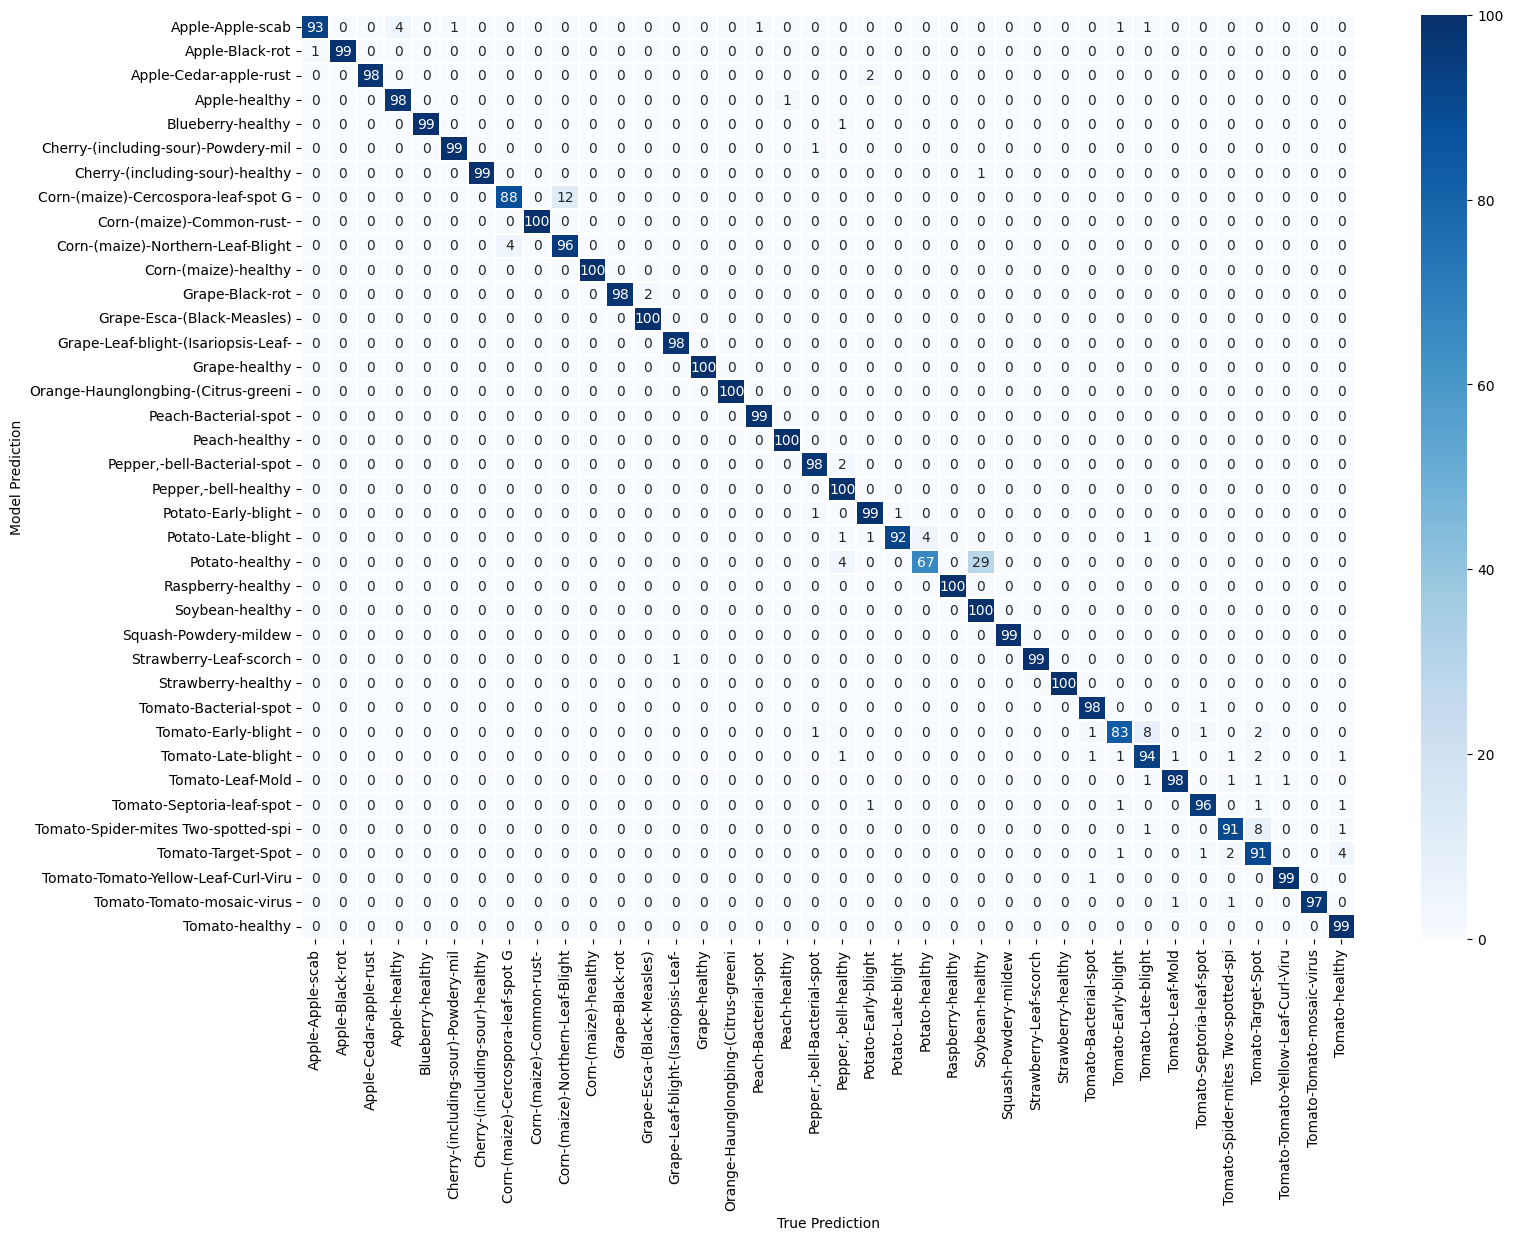

In [547]:
val_p = []
for res in val_results:
    val_p.append(np.argmax(res))

cm = tf.math.confusion_matrix(val_true, val_p)

# Normalize matrics
cmn = []
for cate in cm:
    cate = cate.numpy().astype("float")
    cate = (cate / cate.sum()) * 100
    cmn.append(cate)
cmn
plt.subplots(figsize=(17, 12))
g = sns.heatmap(cmn, yticklabels=short_class_names, cmap="Blues", 
                xticklabels=short_class_names, linewidths=.005, linecolor='#fff', annot=True, fmt='0.0f')
g.set_ylabel('Model Prediction')
g.set_xlabel("True Prediction")

# Save results and model

In [551]:
results = pd.DataFrame(results.history)

In [552]:
# Save to file for python server.
with open("history.json", "w") as history_file:
    results.to_json(history_file)

In [553]:
results_fine_tune = pd.DataFrame(results_fine_tune.history)

In [554]:
# Save to file for python server.
with open("history_fine_tune.json", "w") as history_file:
    results_fine_tune.to_json(history_file)

In [555]:
# Save the model
model.save("image_model", overwrite=True)

2023-06-19 16:24:03.446372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_38_input' with dtype float and shape [?,256,256,3]
	 [[{{node random_flip_38_input}}]]
2023-06-19 16:24:03.623320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256,256,3]
	 [[{{node inputs}}]]
2023-06-19 16:24:03.645742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_38_input' with dtype float an

INFO:tensorflow:Assets written to: image_model/assets


INFO:tensorflow:Assets written to: image_model/assets


# Test results

In [556]:
# Test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(split_dataset_dir, "test"),
    labels="inferred",
    label_mode="int",
    seed=123,
    color_mode="rgb",
    batch_size=64,
    image_size=(256, 256),
    shuffle=False,
)

Found 551 files belonging to 38 classes.


In [557]:
test_results = model.evaluate(test_ds)

2023-06-19 16:28:12.308548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [551]
	 [[{{node Placeholder/_4}}]]
2023-06-19 16:28:12.308840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [551]
	 [[{{node Placeholder/_4}}]]


9/9 [==============================] - 1s 134ms/step - loss: 0.1411 - accuracy: 0.9691


In [558]:
"Test accuracy: {:.4}%".format(test_results[1] * 100)

'Test accuracy: 96.91%'

In [559]:
test_predictions = model.predict(test_ds)

9/9 [==============================] - 1s 82ms/step


In [560]:
# Get validation dataset images true categories.
test_true = []
for i, folder in enumerate(class_names):
    prediction = [i for _ in range(len(filter_list(os.listdir(os.path.join(split_dataset_dir, "test", folder)), 
                                                   ".jpg", 
                                                   ".jpeg", 
                                                   ".png")))]
    test_true.extend(prediction)

Text(0.5, 102.72222222222219, 'True Prediction')

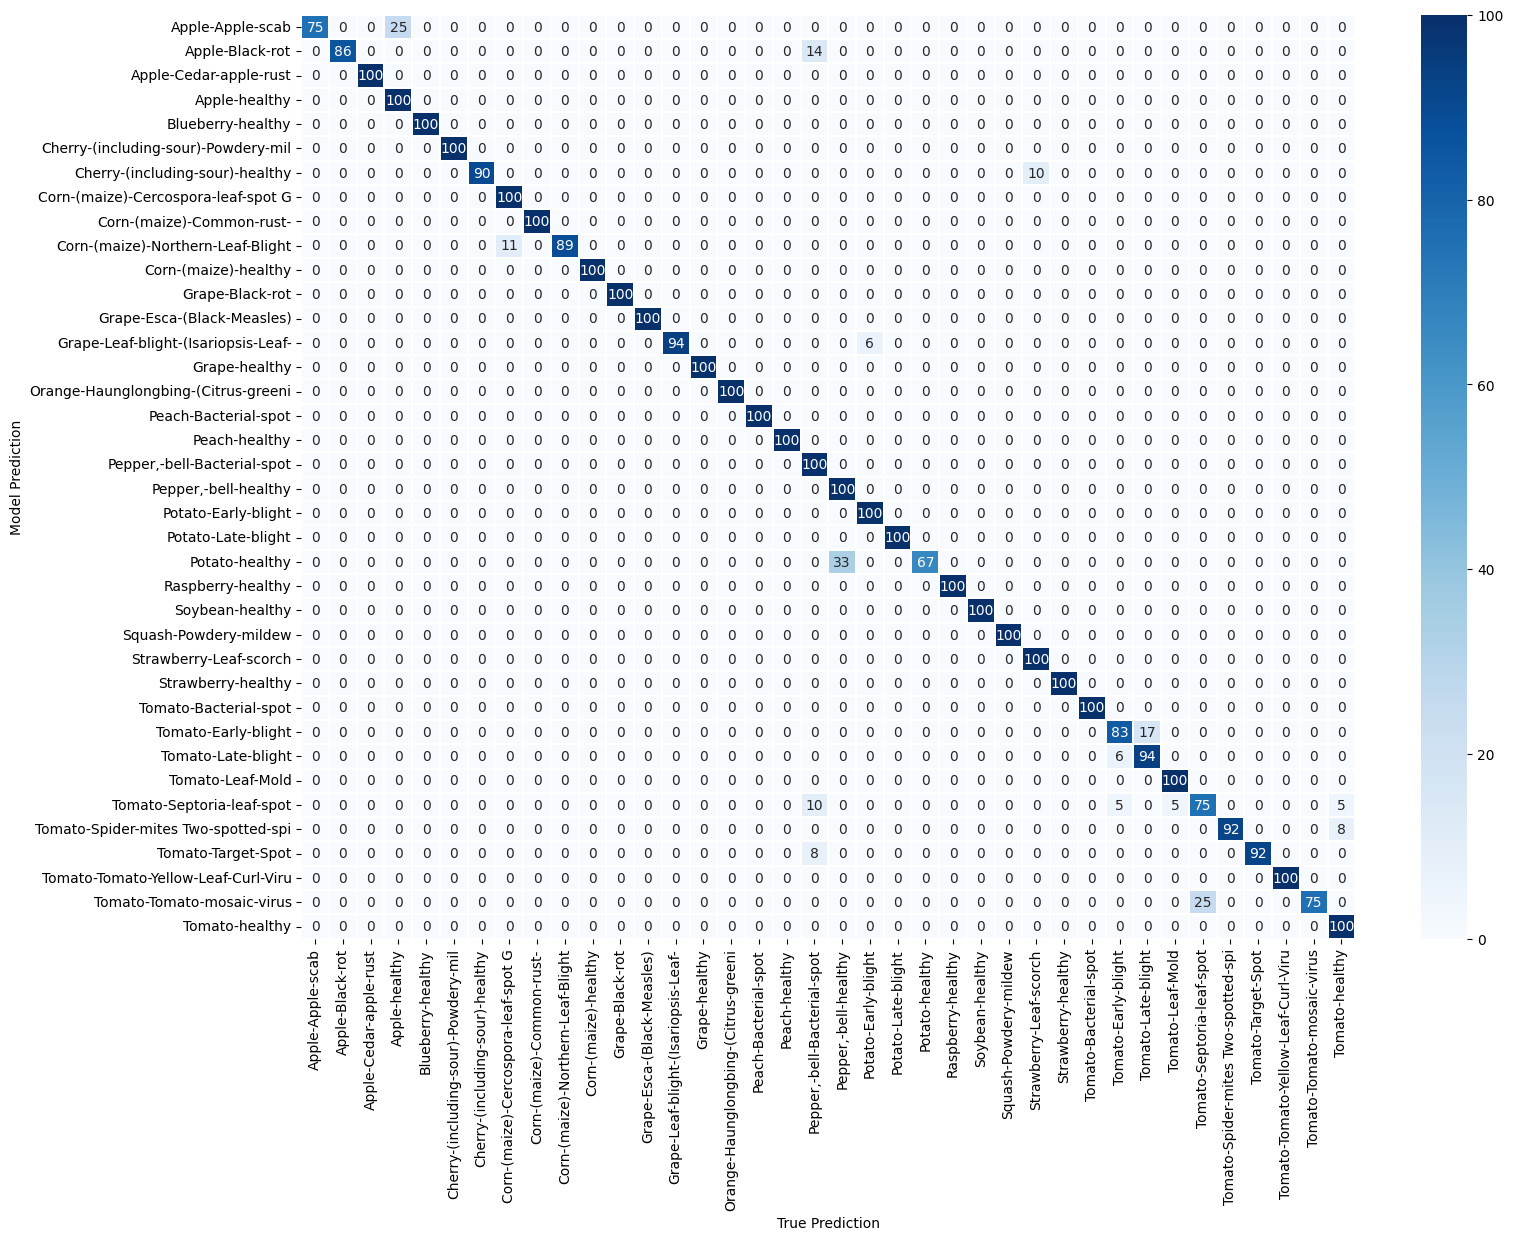

In [562]:
test_p = []
for res in test_predictions:
    test_p.append(np.argmax(res))

cm = tf.math.confusion_matrix(test_true, test_p)

# Normalize matrics
cmn = []
for cate in cm:
    cate = cate.numpy().astype("float")
    cate = (cate / cate.sum()) * 100
    cmn.append(cate)
cmn
plt.subplots(figsize=(17, 12))
g = sns.heatmap(cmn, yticklabels=short_class_names, cmap="Blues", 
                xticklabels=short_class_names, linewidths=.005, linecolor='#fff', annot=True, fmt='0.0f')
g.set_ylabel('Model Prediction')
g.set_xlabel("True Prediction")

In [563]:
# Save to file for python server.
with open("test_results.json", "w") as test_results_file:
    json.dump({"results": {"loss": test_results[0], "accuracy": test_results[1]}}, test_results_file)